# Perturbation Space

pertpy introduces a novel conceptual framework that distinctly delineates between two fundamental domains: the "cell space" and the "perturbation space."
In this paradigm, the cell space encapsulates configurations where discrete data points inherently represent individual cells.
A prevalent manifestation of this pattern can be observed through prominent visualization techniques such as UMAP embeddings as commonly observed in publications.
Conversely, the perturbation space departs from the individualistic perspective of cells and instead organizes cells into cohesive ensembles that have undergone similar perturbations. These grouped cells are subsequently embedded to faithfully encapsulate the nature of the perturbation itself.
This specialized space enables comprehending the collective impact of perturbations on cells.

pertpy offers [several distinct ways](https://pertpy.readthedocs.io/en/latest/usage/usage.html#perturbation-space) of determining the perturbation space that we will introduce in the following.

We will be working with the "mixscape dataset" which encompases a 111 gRNA ECCITE-seq dataset generated from stimulated THP-1 cells.

Reference: Papalexi, E., Mimitou, E.P., Butler, A.W. et al. Characterizing the molecular regulation of inhibitory immune checkpoints with multimodal single-cell screens. Nat Genet 53, 322–331 (2021). [https://doi.org/10.1038/s41588-021-00778-2](https://doi.org/10.1038/s41588-021-00778-2).

## Setup

In [1]:
import pertpy as pt
import scanpy as sc
import mudata as mu

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

To use sccoda or tasccoda please install ete3 with pip install ete3

In [2]:
mdata = mu.read('/home/mila/a/alejandro.tejada/pertpy/docs/tutorials/notebooks/data/papalexi_2021.h5mu')

In [2]:
mdata = pt.dt.papalexi_2021()

Output()

In [3]:
mdata

MuData object with n_obs × n_vars = 20729 × 18776
  4 modalities
    rna:	20729 x 18649
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'
    adt:	20729 x 4
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'
    hto:	20729 x 12
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'
    gdo:	20729 x 111
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'

In [4]:
rna = mdata["rna"].copy()

In [5]:
sc.pp.normalize_total(rna)

In [6]:
sc.pp.log1p(rna)

In [7]:
sc.pp.highly_variable_genes(rna, subset=True)

In [8]:
rna.obs

,orig.ident,nCount_RNA,nFeature_RNA,nCount_HTO,nFeature_HTO,nCount_GDO,nCount_ADT,nFeature_ADT,percent.mito,MULTI_ID,HTO_classification,guide_ID,gene_target,NT,perturbation,replicate,S.Score,G2M.Score,Phase
index,,,,,,,,,,,,,,,,,,,
l1_AAACCTGAGCCAGAAC,Lane1,17207,3942,99.0,4,576.0,801.0,4,2.295577,rep1-tx,rep1-tx,STAT2g2,STAT2,STAT2g2,Perturbed,rep1,-0.252716,-0.771309,G1
l1_AAACCTGAGTGGACGT,Lane1,9506,2948,35.0,5,190.0,545.0,4,4.512939,rep1-tx,rep1-tx,CAV1g4,CAV1,CAV1g4,Perturbed,rep1,-0.123802,-0.332603,G1
l1_AAACCTGCATGAGCGA,Lane1,15256,4258,66.0,4,212.0,344.0,4,4.116413,rep1-tx,rep1-tx,STAT1g2,STAT1,STAT1g2,Perturbed,rep1,-0.154633,-0.694418,G1
l1_AAACCTGTCTTGTCAT,Lane1,5135,1780,22.0,3,243.0,539.0,4,5.491723,rep1-tx,rep1-tx,CD86g1,CD86,CD86g1,Perturbed,rep1,-0.061262,-0.037820,G1
l1_AAACGGGAGAACAACT,Lane1,9673,2671,99.0,5,198.0,1053.0,4,3.359868,rep1-tx,rep1-tx,IRF7g2,IRF7,IRF7g2,Perturbed,rep1,-0.132188,-0.353156,G1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l8_TTTGTCAGTCACTTCC,Lane8,20863,4884,294.0,4,290.0,398.0,4,5.469012,rep3-tx,rep3-tx,CMTM6g1,CMTM6,CMTM6g1,Perturbed,rep3,-0.323562,-0.794679,G1
l8_TTTGTCAGTGACGGTA,Lane8,17553,3787,528.0,3,870.0,3042.0,4,2.159175,rep4-tx,rep2-tx,NTg4,NT,NT,NT,rep2,-0.153514,-0.632655,G1
l8_TTTGTCAGTTCCACAA,Lane8,15106,4185,154.0,6,267.0,212.0,4,2.661194,rep3-tx,rep3-tx,ATF2g1,ATF2,ATF2g1,Perturbed,rep3,-0.191933,-0.574283,G1


## Pseudobulk Space

The Pseudobulk space returns an Anndata in which each observation corresponds to the pseudobulk expression of all cells with a given perturbation.

In [10]:
ps = pt.tl.PseudobulkSpace()
psadata = ps.compute(rna, target_col="gene_target", groups_col="gene_target", mode="mean", min_cells=0, min_counts=0)

In [11]:
psadata

AnnData object with n_obs × n_vars = 26 × 1917
    obs: 'gene_target', 'perturbation', 'psbulk_n_cells', 'psbulk_counts'
    var: 'name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'psbulk_props'

In [12]:
psadata.obs.head()

,gene_target,perturbation,psbulk_n_cells,psbulk_counts
ATF2,ATF2,Perturbed,1102.0,614397.250000
BRD4,BRD4,Perturbed,341.0,175617.890625
CAV1,CAV1,Perturbed,882.0,487257.593750
CD86,CD86,Perturbed,1197.0,663038.125000
CMTM6,CMTM6,Perturbed,817.0,450578.250000


In the generated Anndata, each observation is a perturbation and its expression is the `mode` of the PseudobulkSpace function.

Now the perturbation space can be visualised, query and be subject of different operations.

In [13]:
psadata.obs.gene_target = psadata.obs.gene_target.astype('category')

In [14]:
sc.tl.pca(psadata)

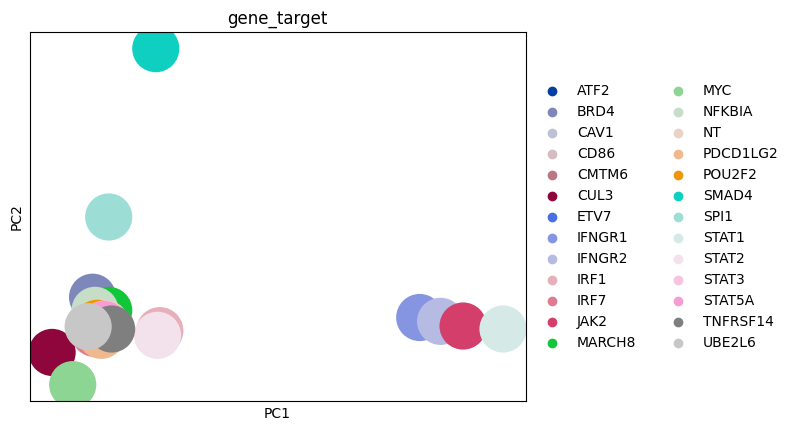

In [15]:
sc.pl.pca(psadata, color='gene_target')

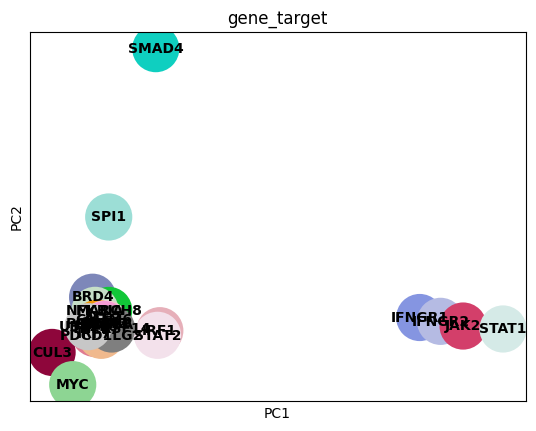

In [16]:
sc.pl.pca(psadata, color='gene_target', legend_loc='on data')

From the visualization of the perturbational space, one can see that there exist three clear groups of perturbations. 
The first group seems to have subtle effects since they are clustered together with `NT`, which is the `no-targeting` guide.
The second group clusters perturbations such as `STAT1`, `JAK2` or `IFNGR1`.
Finally, the third group is uniquely constituted by `SMAD4`. The perturbational effect of each group is different.

## Discriminator Classifier

The Discriminator Classifier embedding method trains a NN classifier to predict which perturbation has been applied to each cell. Once the training has finished, if get the representations of the last layer as embedding of the perturbations.

In [36]:
ps = pt.tl.DiscriminatorClassifierSpace()

The `load` method creates the model to train and the dataloaders. It accepts different hyperparameters related with the architecture of the model such as `hidden_dim`, `dropout`, `batch_norm`, etc. 
Training hyperparameters such as `batch_size`, `test_split_size`, `validation_split_size` can also be changed.

In [37]:
classifier_ps = ps.load(rna, target_col="gene_target", hidden_dim=[512, 256], dropout=0.05)

Let's train just for a few epochs. The trainer uses GPU if available.

In [38]:
classifier_ps.train(max_epochs=20)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
0 | net  | MLP  | 1.1 M 
------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.486     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    2.7912514209747314     │
└───────────────────────────┴───────────────────────────┘

In [47]:
pert_embeddings = classifier_ps.get_embeddings()

The embeddings are extracted from the last layer (256, as previously set), and are the representation of each cell. Therefore, PseudobulkSpace or any other transformation can be applied to further investigate the space.

In [48]:
pert_embeddings.obs

,perturbations
0,STAT2
1,CAV1
2,STAT1
3,CD86
4,IRF7
...,...
244,CMTM6
245,NT
246,ATF2
247,CAV1


In [49]:
ps = pt.tl.PseudobulkSpace()
psadata = ps.compute(pert_embeddings,  mode="mean", min_cells=0, min_counts=0)

In [50]:
psadata.obs.head()

,perturbations,psbulk_n_cells,psbulk_counts
ATF2,ATF2,1102.0,99193.234375
BRD4,BRD4,341.0,29708.853516
CAV1,CAV1,882.0,78942.617188
CD86,CD86,1197.0,105509.265625
CMTM6,CMTM6,817.0,72084.515625


In [51]:
psadata.obs.perturbations = psadata.obs.perturbations.astype('category')

In [52]:
sc.tl.pca(psadata)

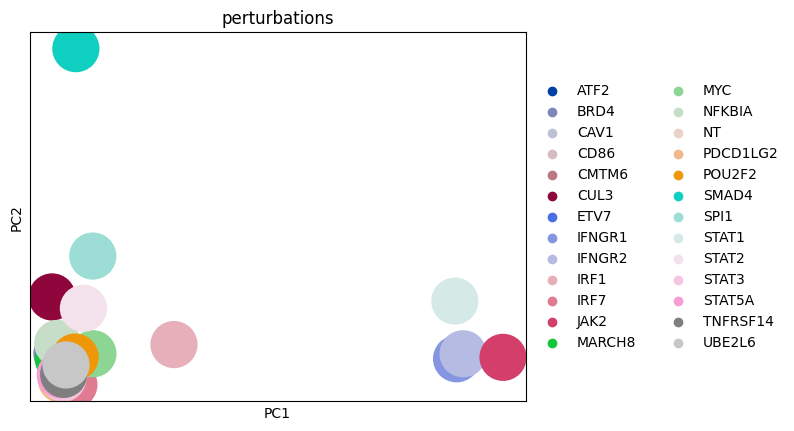

In [53]:
sc.pl.pca(psadata, color='perturbations')

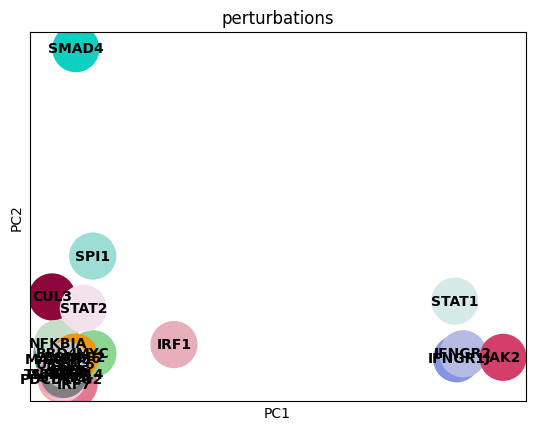

In [54]:
sc.pl.pca(psadata, color='perturbations', legend_loc='on data')

As it can be seen with the PCA of the generated space, the results are quite similar, there still exists three clear groups of perturbations according to their effects.

## Centroid Space

The Centroid Space computes the centroids per perturbation of a pre-computed embedding. So we first need to compute an embedding in the original dataset.

In [9]:
sc.tl.pca(rna)
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=40)
sc.tl.umap(rna)

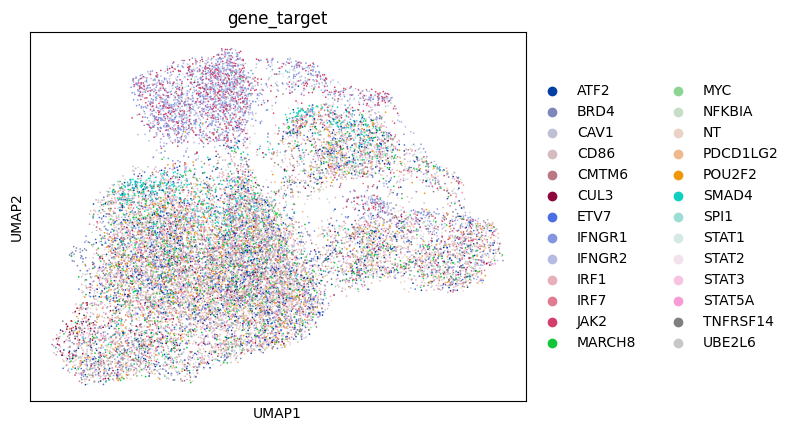

In [10]:
sc.pl.umap(rna, color="gene_target")

In [11]:
ps = pt.tl.CentroidSpace()
psadata = ps.compute(rna, target_col="gene_target", embedding_key="X_umap")

In [12]:
psadata

AnnData object with n_obs × n_vars = 26 × 2
    obs: 'gene_target'
    obsm: 'X_umap'

In [15]:
psadata.obs.gene_target = psadata.obs.gene_target.astype('category')

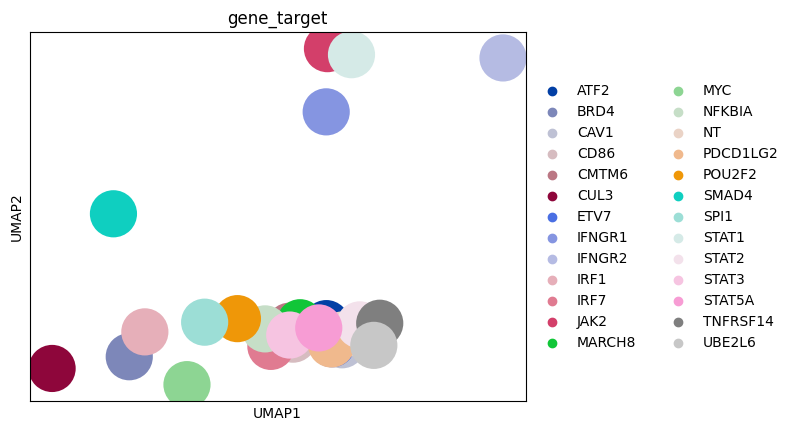

In [16]:
sc.pl.umap(psadata, color="gene_target")

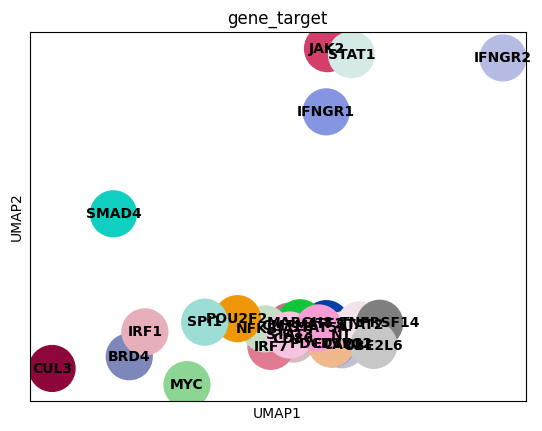

In [17]:
sc.pl.umap(psadata, color="gene_target", legend_loc='on data')

In this plot it can been identified again three clusters. Those are the same three clusters that appear in all the other generated Perturbational Spaces: A main one with most of the perturbations around `NT`. A small one with just `SMAD4`. `JAK2`, `STAT1`, `IFNGR2` and `IFNGR1`.

## DBScan Space

It clusters the given data using DBSCAN. It admits any option from the original sklearn DBSCAN function.

In [9]:
ps = pt.tl.DBSCANSpace()
adata = ps.compute(rna, min_samples=100, copy=True)

In [ ]:
adata

In [ ]:
results = ps.evaluate_clustering(adata, true_label_col="perturbations", cluster_col="k-means", metric="l1")

plot interpretation

## K-Means Space

It clusters the given data using DBSCAN. It admits any option from the original sklearn DBSCAN function.

In [9]:
ps = pt.tl.KMeansSpace()
adata = ps.compute(rna, n_clusters=26, copy=True)

In [10]:
adata

AnnData object with n_obs × n_vars = 20729 × 1917
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase', 'k-means'
    var: 'name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [11]:
results = ps.evaluate_clustering(adata, true_label_col="gene_target", cluster_col="k-means", metric="l2")

In [14]:
results

{'nmi': 0.08460674293686779, 'ari': 0.025376124943725657, 'asw': -0.07754745}

In [12]:
sc.tl.pca(adata)

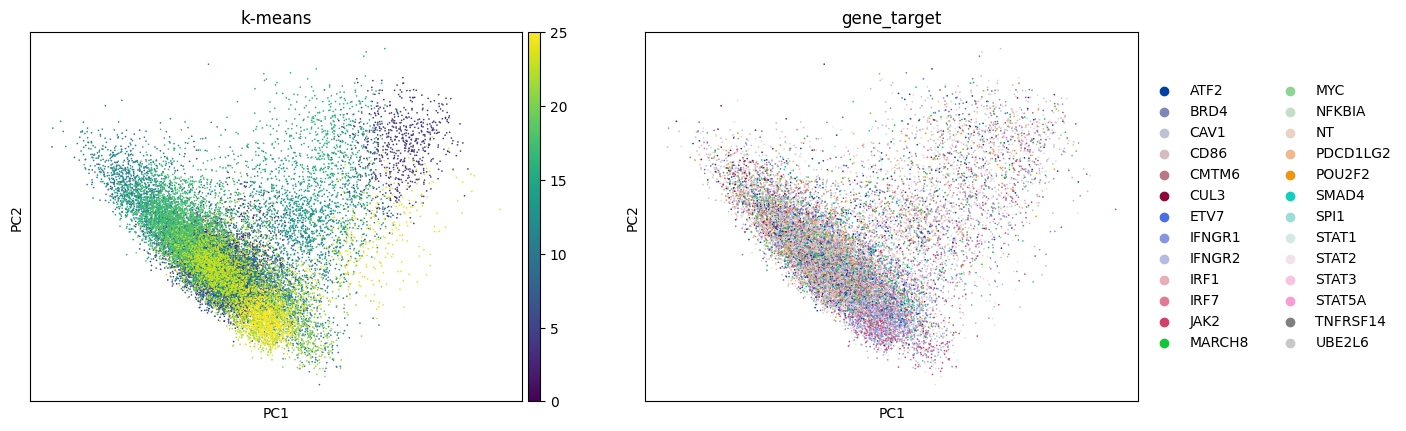

In [13]:
sc.pl.pca(adata, color=['k-means', 'gene_target'])

In [15]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

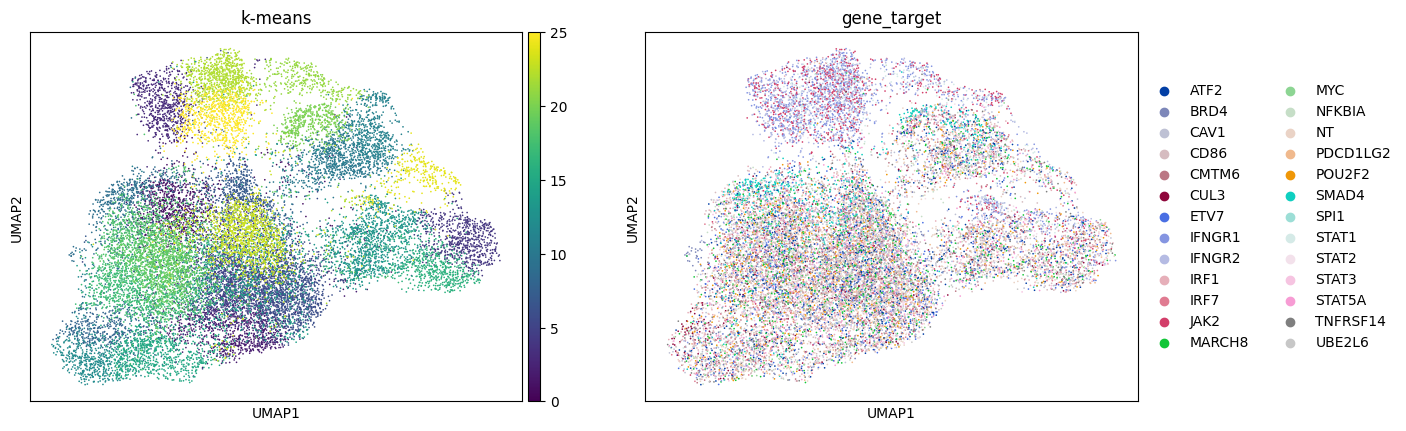

In [16]:
sc.pl.umap(adata, color=['k-means', 'gene_target'])

plot interpretation

## Conclusion

bla.